### Define modules

Echo state networkの基本的な構成単位を定義する．

- 入力層
- リザーバー
- 出力層

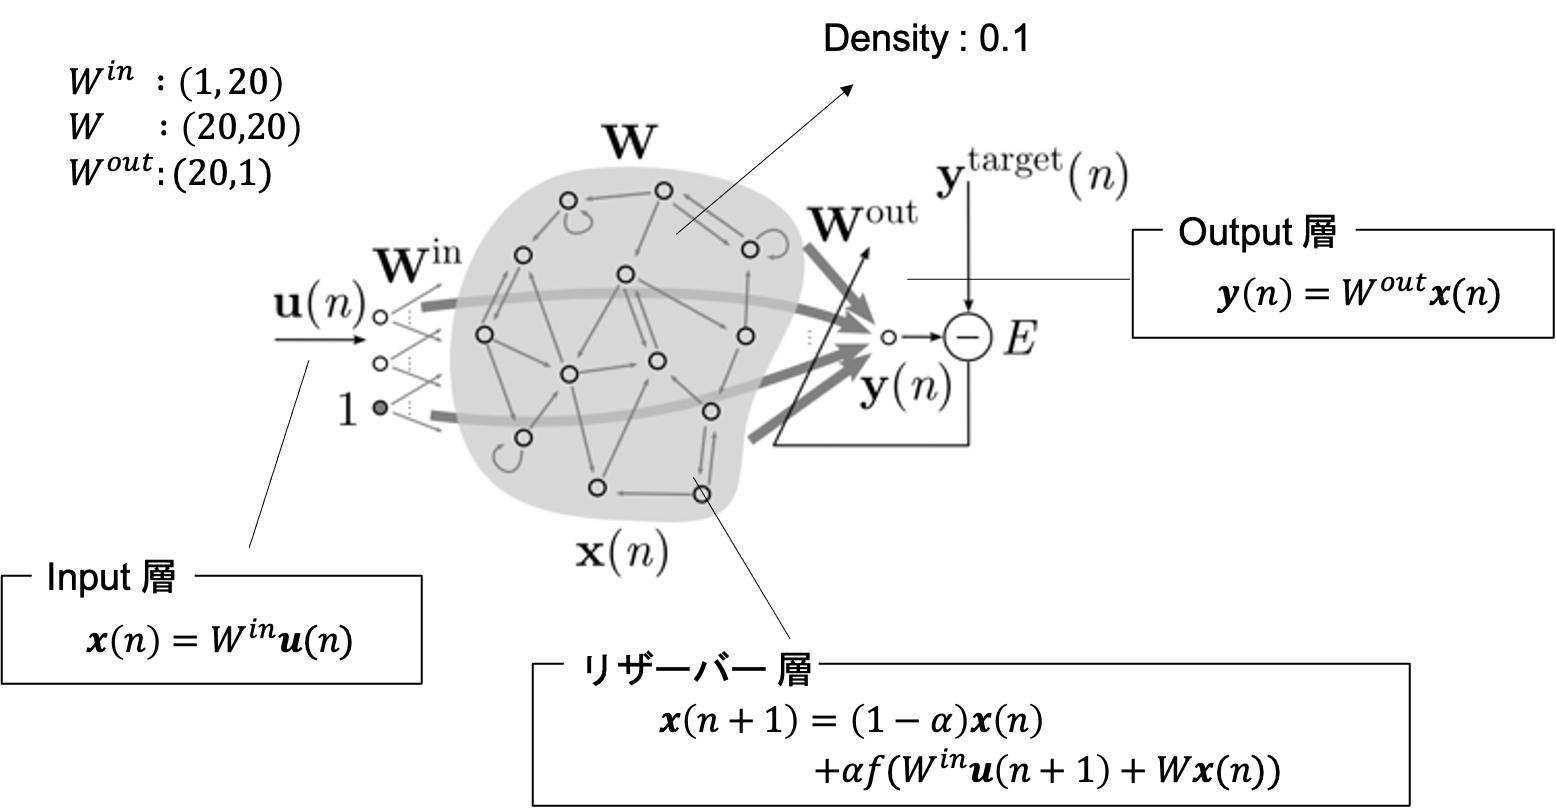

参考　：p.45 図3.1

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#################################################################
# 田中，中根，廣瀬（著）「リザバーコンピューティング」（森北出版）
# 本ソースコードの著作権は著者（田中）にあります．
# 無断転載や二次配布等はご遠慮ください．
#
# model.py: エコーステートネットワークのモジュール
#################################################################


入力層：${\bf x}(n)=W^{in}{\bf u}(n)$

> $W^{in}$:入力結合重み\
> ${\bf x}(n)=(u_1(n), u_2(n), \dots, u_{N_u}(n))^{\rm T}$\
> ${\bf u}(n)=(u_1(n), u_2(n), \dots, u_{N_u}(n))^{\rm T}$


In [31]:
import numpy as np
import networkx as nx

# 恒等写像
def identity(x):
    return x

# 入力層
class Input:
    # 入力結合重み行列Winの初期化
    def __init__(self, N_u, N_x, input_scale, seed=0):
        '''
        param N_u: 入力次元
        param N_x: リザバーのノード数
        param input_scale: 入力スケーリング
        '''
        # 一様分布に従う乱数
        np.random.seed(seed=seed)
        self.Win = np.random.uniform(-input_scale, input_scale, (N_x, N_u))

    # 入力結合重み行列Winによる重みづけ
    def __call__(self, u):
        '''
        param u: N_u次元のベクトル
        return: N_x次元のベクトル
        '''
        return np.dot(self.Win, u)


リザバー  :Leaky Integrator model
> ${\bf x}(n+1)=(1-\alpha){\bf x}(n)+\alpha f(W^{in}{\bf u}(n+1)+W{\bf x}(n))$\
> ただし， \
> $W$リザーバー内の結合重み\
> $\alpha \in (0,1]$

参考：p.49 式（3.20）
\
\
__init__:\
リザーバーの定義

__make_connection__:\
リザーバー内の結合重み$W$の定義・ランダムな初期化\
ESPを満たすために，絶対値最大固有値によるスケーリング

__call__:\
リザーバー状態ベクトルの更新


In [32]:
# リザバー
class Reservoir:
    # リカレント結合重み行列Wの初期化
    def __init__(self, N_x, density, rho, activation_func, leaking_rate, seed=0):
        '''
        param N_x: リザバーのノード数
        param density: ネットワークの結合密度
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: ノードの活性化関数
        param leaking_rate: leaky integratorモデルのリーク率
        param seed: 乱数の種
        '''
        self.seed = seed
        self.W = self.make_connection(N_x, density, rho)
        self.x = np.zeros(N_x)  # リザバー状態ベクトルの初期化
        self.activation_func = activation_func
        self.alpha = leaking_rate

    # リカレント結合重み行列の生成
    def make_connection(self, N_x, density, rho):
        # Erdos-Renyiランダムグラフ
        m = int(N_x*(N_x-1)*density/2)  # 総結合数
        G = nx.gnm_random_graph(N_x, m, self.seed)

        # 行列への変換(結合構造のみ）
        connection = nx.to_numpy_matrix(G)
        W = np.array(connection)

        # 非ゼロ要素を一様分布に従う乱数として生成
        rec_scale = 1.0
        np.random.seed(seed=self.seed)
        W *= np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

        # スペクトル半径の計算
        eigv_list = np.linalg.eig(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # 指定のスペクトル半径rhoに合わせてスケーリング
        W *= rho / sp_radius

        return W

    # リザバー状態ベクトルの更新
    # Leaky Integrator model → p.49 式（3.20）
    #
    def __call__(self, x_in):
        '''
        param x_in: 更新前の状態ベクトル
        return: 更新後の状態ベクトル
        '''
        #self.x = self.x.reshape(-1, 1)
        self.x = (1.0 - self.alpha) * self.x + self.alpha * self.activation_func(np.dot(self.W, self.x) + x_in)
        return self.x

    # リザバー状態ベクトルの初期化
    def reset_reservoir_state(self):
        self.x *= 0.0

出力層

> ${\bf y}(n)=W^{out}{\bf x}(n)$

In [33]:
# 出力層
class Output:
    # 出力結合重み行列の初期化
    def __init__(self, N_x, N_y, seed=0):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param seed: 乱数の種
        '''
        # 正規分布に従う乱数
        np.random.seed(seed=seed)
        self.Wout = np.random.normal(size=(N_y, N_x))

    # 出力結合重み行列による重みづけ
    def __call__(self, x):
        '''
        param x: N_x次元のベクトル
        return: N_y次元のベクトル
        '''
        return np.dot(self.Wout, x)

    # 学習済みの出力結合重み行列を設定
    def setweight(self, Wout_opt):
        self.Wout = Wout_opt

線形回帰を直接計算\
dはスカラー
> $W^{out} = d{\bf x}^{\rm T}({\bf x}{\bf x}^{\rm T})^{-1}$

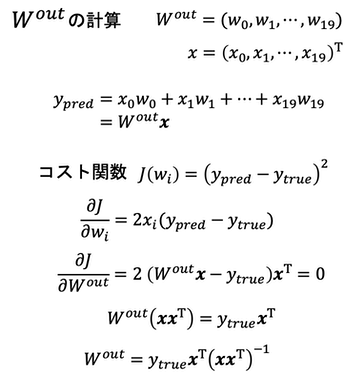


In [34]:
# リッジ回帰（beta=0のときは線形回帰）
class Tikhonov:
    def __init__(self, N_x, N_y, beta):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param beta: 正則化パラメータ　　　今回は０
        '''
        self.beta = beta
        self.X_XT = np.zeros((N_x, N_x))
        self.D_XT = np.zeros((N_y, N_x))
        self.N_x = N_x

    # 学習用の行列の更新
    def __call__(self, d, x):
        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        self.X_XT += np.dot(x, x.T)
        self.D_XT += np.dot(d, x.T)

    # Woutの最適解（近似解）の導出
    def get_Wout_opt(self):
        X_pseudo_inv = np.linalg.inv(self.X_XT + self.beta*np.identity(self.N_x))
        Wout_opt = np.dot(self.D_XT, X_pseudo_inv)
        return Wout_opt

### ESN の定義

核となる部分
```
#train 関数の中
# 時間発展
for n in range(train_len):
    x_in = self.Input(U[n])   →   x(n) = Win*u(n) = x_in

    # リザバー状態ベクトル
    x = self.Reservoir(x_in)   →  x(n) = (1-α)x(n-1) + α f（Win*u(n) + W*x(n-1)）
                                       = (1-α)x(n-1) + α f（x_in + W*x(n-1)）  
                                       f：activation function ここでは　tanh

    # 目標値
    d = D[n]
    d = self.inv_output_func(d)  → ここでは，output function は　恒等関数だから，逆関数も恒等関数．

    # 学習器
    if n > trans_len:  # 過渡期を過ぎたら　→  入力データの長さ分待つ．　ここでは，　trans_len = 48
        optimizer(d, x)

    # 学習前のモデル出力
    y = self.Output(x)                 →   y = Wout*x
    Y.append(self.output_func(y))     →   output function は恒等関数
    self.y_prev = d
```


In [35]:
# エコーステートネットワーク
class ESN:
    # 各層の初期化
    def __init__(self, N_u, N_y, N_x, density=0.05, input_scale=1.0,
                 rho=0.95, activation_func=np.tanh, leaking_rate=1.0,
                 output_func=identity, inv_output_func=identity):
        '''
        param N_u: 入力次元
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param density: リザバーのネットワーク結合密度
        param input_scale: 入力スケーリング
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: リザバーノードの活性化関数
        param leaking_rate: leaky integratorモデルのリーク率
        param output_func: 出力層の非線形関数（default: 恒等写像）
        param inv_output_func: output_funcの逆関数
        '''
        self.Input = Input(N_u, N_x, input_scale)
        self.Reservoir = Reservoir(N_x, density, rho, activation_func, 
                                   leaking_rate)
        self.Output = Output(N_x, N_y)
        self.N_u = N_u
        self.N_y = N_y
        self.N_x = N_x
        self.y_prev = np.zeros(N_y)
        self.output_func = output_func
        self.inv_output_func = inv_output_func

    # バッチ学習
    def train(self, U, D, optimizer, trans_len = None):
        '''
        U: 教師データの入力, データ長×N_u
        D: 教師データの出力, データ長×N_y
        optimizer: 学習器
        trans_len: 過渡期の長さ
        return: 学習前のモデル出力, データ長×N_y
        '''
        train_len = len(U)
        print("train_len is " + str(train_len))
        if trans_len is None:
            trans_len = 0
        Y = []

        # 時間発展
        for n in range(train_len):
            x_in = self.Input(U[n]) 

            # リザバー状態ベクトル
            x = self.Reservoir(x_in)

            # 目標値
            d = D[n]
            d = self.inv_output_func(d)

            # 学習器
            if n > trans_len:  # 過渡期を過ぎたら
                optimizer(d, x)

            # 学習前のモデル出力
            y = self.Output(x)
            Y.append(self.output_func(y))

        # 学習済みの出力結合重み行列を設定
        self.Output.setweight(optimizer.get_Wout_opt())

        # モデル出力（学習前）
        return np.array(Y)

    # バッチ学習後の予測
    def predict(self, U):
        test_len = len(U)
        Y_pred = []

        # 時間発展
        for n in range(test_len):
            x_in = self.Input(U[n])

            # リザバー状態ベクトル
            x = self.Reservoir(x_in)

            # 学習後のモデル出力
            y_pred = self.Output(x)
            Y_pred.append(self.output_func(y_pred))
            self.y_prev = y_pred

        # モデル出力（学習後）
        return np.array(Y_pred)

### Training

In [36]:
import matplotlib.pyplot as plt

np.random.seed(seed=0)

# 時系列入力データ
T = 50  # 時間長
u = np.random.randint(0, 2, T)  # 2値系列

# 時系列出力データ
tau = 2  
d = np.zeros(T)
for n in range(tau, T):
    d[n] = u[n-1]^u[n-2]  # XOR関数

# 実数に変換
u = u.astype(np.float)
d = d.astype(np.float)

# 学習用情報
train_U = u[tau:T].reshape(-1, 1)
train_D = d[tau:T].reshape(-1, 1)

# ESNモデル
N_x = 20  # リザバーのノード数
# train_U.shape[1] = 1, train_D.shape[1] = 1 
model = ESN(train_U.shape[1], train_D.shape[1], N_x, density=0.1, input_scale=1.0, rho=0.9)

# 学習（線形回帰）
model.train(train_U, train_D, Tikhonov(N_x, train_D.shape[1], 0.0))

# モデル出力
train_Y = model.predict(train_U)

# 評価（ビット誤り率, BER）
train_Y_binary = np.zeros(T-tau)
for n in range(T-tau):
    if train_Y[n, 0] > 0.5:
        train_Y_binary[n] = 1
    else:
        train_Y_binary[n] = 0
    
BER = np.linalg.norm(train_Y_binary[0:T-tau]-d[tau:T], 1)/(T-tau)
print('BER =', BER)

train_len is 48
BER = 0.0


### 可視化

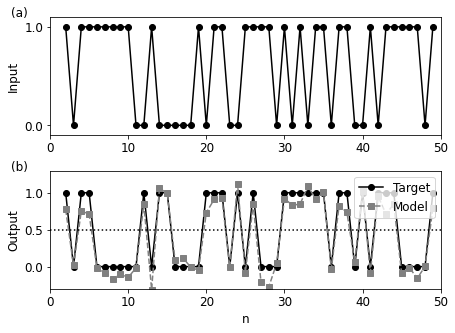

In [37]:
# グラフ表示用データ
T_disp = (0, T)
t_axis = np.arange(tau, T)  # 時間軸
disp_U = train_U[T_disp[0]:T_disp[1]]  # 入力
disp_D = train_D[T_disp[0]:T_disp[1], :]  # 目標出力
disp_Y = train_Y[T_disp[0]:T_disp[1], :]  # モデル出力

# グラフ表示
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2, 1, 1)
ax1.text(-0.1, 1, '(a)', transform=ax1.transAxes)
ax1.set_yticks([0.0, 1.0])
plt.plot(t_axis, disp_U[:, 0], color='k', marker='o')
plt.xlim([0, T])
plt.ylim([-0.1, 1.1])
plt.ylabel('Input')
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

ax2 = fig.add_subplot(2, 1, 2)
ax2.text(-0.1, 1, '(b)', transform=ax2.transAxes)
ax2.set_yticks([0, 0.5, 1])
plt.plot(t_axis, disp_D[:, 0], color='k', marker='o', label='Target')
plt.plot(t_axis, disp_Y[:, 0], color='gray', marker='s', 
          linestyle = '--', label='Model')
plt.plot([0, T], [0.5, 0.5], color='k', linestyle = ':')
plt.xlim([0, T])
plt.ylim([-0.3,1.3])
plt.xlabel('n')
plt.ylabel('Output')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right')

plt.show()